# The Paired *t*-test
As we have now seen, correlation causes problems in terms of accurately capturing the uncertainty of our parameter estimates. If our data are dependent, we need to include this in the model somehow otherwise our inference will be inaccurate. This is not just a problem for NHST, it is a problem for any inferential method that requires a measure of *uncertainty* about the parameter values. In this part of the lesson, we will turn to the most basic approach for dealing with dependent data: the *paired* $t$-test. 


## Two-sample vs Paired *t*-tests
From your statistical education so far, you should be aware that there are two variants of the basic $t$-test for multiple samples. The first is the traditional *two-sample* test, and the second is the *paired* test. The *two-sample* test is suitable for cases when the data from two groups are *independent*, whereas the *paired* test is suitable for cases when the data come from repeated measurements. As the name implies, we think of the data as *pairs* of values that each subject has provided. Because they come from the same subject, the pairs will be *correlated* and thus the test must be adjusted. *How* this is done is really the focus of this section. 

### Why Does the Paired Test Differ?
Rather then working up to the paired $t$-test from first principles, we will instead start from the top by examining the results that `R` gives us for both a *two-sample* and *paired* test. We can then start working out *why* the *paired* results differ from the *two-sample* results. Playing Statistical Detective&trade; in this fashion can be insightful in terms of helping us unpack what is going on and, most importantly, *why* the tests work this way.

To begin, let us examine the difference between the results of the `t.test()` function, with `paired=FALSE` and `paired=TRUE` [^foot2]. To do this, we first simulate correlated data as we did before

In [1]:
library(MASS)
set.seed(666)

var1  <- var2 <- 1
rho   <- 0.8
covar <- rho*sqrt(var1)*sqrt(var2)

Sigma <- matrix(data=c(var1,covar,covar,var2), nrow=2, ncol=2)
y     <- mvrnorm(n=50, mu=c(1,1.25), Sigma=Sigma)

We can then run a *two-sample* $t$-test using

In [2]:
t.test(x=y[,1], y=y[,2], paired=FALSE, var.equal=TRUE)


	Two Sample t-test

data:  y[, 1] and y[, 2]
t = -0.92759, df = 98, p-value = 0.3559
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6487683  0.2354578
sample estimates:
mean of x mean of y 
0.9601951 1.1668504 


and compare the output to a *paired* $t$-test on the same data

In [3]:
t.test(x=y[,1], y=y[,2], paired=TRUE,  var.equal=TRUE)


	Paired t-test

data:  y[, 1] and y[, 2]
t = -2.4952, df = 49, p-value = 0.01601
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -0.3730884 -0.0402221
sample estimates:
mean difference 
     -0.2066553 


Perhaps the first thing you will notice is that the two-sample $t$-test is *non-significant*, whereas the paired $t$-test is *significant*. However, there is a lot more to unpack here. 

The output from the *two-sample* test reports the estimated group means as $\hat{\mu}_{1} = 0.96$ and $\hat{\mu}_{2} = 1.17$, meaning that the estimated mean difference is $\hat{\mu}_{1} - \hat{\mu}_{2} = 0.96 - 1.17 = -0.21$. This is the same as reported by the *paired* test. As such, the difference between these methods is *not* related to the estimated mean difference.

Where the two tests differ can be seen in terms of the $t$-statistic itself, the degrees of freedom and the confidence interval, as summarised below 

| Test       | *t*-statistic | DoF | *p*-value | 95% CI          | 
| ---------- | ------------- | --- | --------- | --------------- |
| Two-sample | -0.928        | 98  | 0.356     | [-0.649  0.235] |
| Paired     | -2.495        | 49  | 0.016     | [-0.373 -0.040] |

As we know, structure of the $t$-statistic is

$$
t = \frac{\mu_{1} - \mu_{2}}{\text{SE}\{\mu_{1} - \mu_{2}\}},
$$

meaning that we think of the $t$ as the ratio between the *mean difference* and the *standard error of the mean difference*. Given that the mean difference is the same across both methods, the numerator of the test statistic must be identical under both the *two-sample* and *paired* tests. As such, the difference in the $t$ values has to be coming from a difference in the denominator. In other words, the standard error of the difference changes between the *two-sample* and *paired* cases.

This should not be a surprise, given our earlier discussion of the influence of correlation on the standard error. If the correlation is *positive*, then we expect the standard error to be *smaller*. Indeed, this is what we see here. In both cases, we can recover the standard error by dividing the mean difference by the $t$-statistic. This gives

In [4]:
round(c(-0.207/-0.928, -0.207/-2.495), digits=3)

[1] 0.223 0.083

So, in the *two-sample* case the standard error is $0.223$, which is larger than the standard error in the *paired* case, which is $0.083$. 

### Checking the Standard Error Using Simulation
Given what we know, the conclusion would be that the estimate in the *two-sample* case is *too large*, given the correlation in the data. We can appeal to theory to confirm this, but we can also see that this true using simulation. In the code below, we run 5,000 simulations. In each case, we draw 50 pairs from the theoretical multivariate normal distribution with the given covariance matrix. We calculate the mean difference and then save it. After all 5,000 repetitions, we can plot the simulated sampling distribution of the mean difference and estimate the standard error.


Loading required package: survival


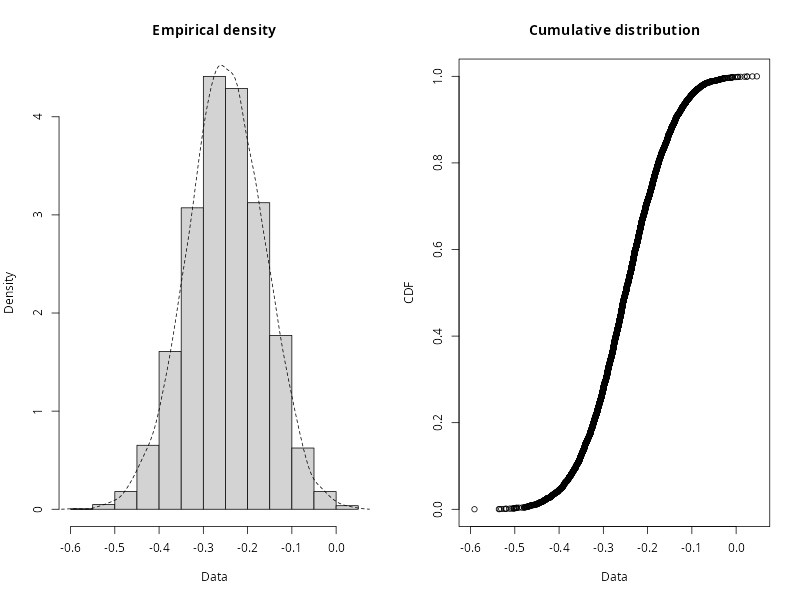

In [5]:
library('fitdistrplus')
set.seed(666)

var1  <- 1
var2  <- 1
rho   <- 0.8
covar <- rho*sqrt(var1)*sqrt(var2)
Sigma <- matrix(data=c(var1,covar,covar,var2), nrow=2, ncol=2)

mu_diff   <- rep(0,5000)
for (i in 1:5000){
    y.sim      <- mvrnorm(n=50, mu=c(1,1.25), Sigma=Sigma)
    mu_diff[i] <- mean(y.sim[,1]) - mean(y.sim[,2])
}

plotdist(mu_diff, histo=TRUE, demp=TRUE)

The standard error from the simulations is then given by

In [6]:
round(sd(mu_diff), digits=3)

[1] 0.088

This is very close to estimated standard error of 0.083 from the *paired* test, and is not anywhere near the estimated standard error of 0.223 from the *two-sample* test. As such, we can see that the *paired* test is able to accurately estimate the correct standard error under cases of correlation. 

This should not be surprising, however, the key question for us is *how* the *paired* $t$-test is able to do this.

## Modelling the *Difference*
The first method we can use is actually a bit of a *cheat* in order to side-step the issue of dependence entirely. However, conceptually, this is a really key step because it introduces the idea that we can correctly model repeated measurements by *removing something from the data*. In this first method, we remove it manually by subtracting the two repeats and analysing the *difference*. Further below we will see how this removal can be done *within the model itself*.

... So the key insight is that when we take $D_{i} = y_{i1} - y_{i2}$, we have *removed* some element from the data that allows us to analyse the difference between the conditions without taking correlation into account. How is this possible? Precisely because, by subtracting these two values, we have *removed* the correlation. Thus, there is some shared component between $y_{i1}$ and $y_{i2}$ that cancels-out when we subtract them. In cancelling-out, the correlation is gone and we can treat $D_{i}$ as a vector of independent measurements. 

We can get more clarity on this by writing it formally. Let us *add* a shared component to the definition of both $y_{i1}$ and $y_{i2}$. We will call this $S_{i}$

$$
\begin{alignat*}{1}
    y_{i1} &= \mu_{1} + S_{i} + \epsilon_{i1} \\
    y_{i2} &= \mu_{2} + S_{i} + \epsilon_{i2} 
\end{alignat*}.
$$

So, the reason why $y_{i1}$ and $y_{i2}$ are correlated is because they *share* the same component $S_{i}$. This captures the idea that these measurements come the same *subject*. If we then *subtract* these values, $S_{i}$ will cancel-out

$$
\begin{alignat*}{1}
    (y_{i1} - y_{i2}) = D_{i} &= (\mu_{1} - \mu_{2}) + (S_{i} - S_{i}) + (\epsilon_{i1} - \epsilon_{i2}) \\
                              &= \mu^{(D)} + \epsilon_{i}^{(D)}
\end{alignat*}.
$$

So, this tells us that $S_{i}$ precisely captures the correlation, because removing it renders the data *independent*. 

### Partitioning the Error



To begin with, let us just examine the overall variance of the data for the first 15 subjects.

In [7]:

subject <- rep(seq(1,50),each=2)
subject <- as.factor(subject)

plot(as.numeric(subject)[1:30],
     y.long[1:30],
     col=as.factor(cond),
     xlab='Subject',
     ylab='Y',
     pch=16)

abline(h=mean(y.long))


: [1m[33mError[39m:[22m
[33m![39m object 'y.long' not found

Here we can see that there are 3 main sources of variation in these data:

1. The two conditions have different means, thus measures from one condition tend to be larger than the other. In this example, the mean difference is only 0.21, so this is quite a subtle effect. But it is there. This is the *structured* variance we are interested in (can't remember what term was used for this?)
2. The data come from different subjects, thus the degree to which the data fall above or below the grand means depends upon the individual subject. This is one source of *error variance* that explains why the data deviate from their expected value.
3. Within each subject, there is variation between the two measures. The magnitude of this difference is sometimes bigger and sometimes smaller than the condition difference of 0.21. This is *another* source of *error variance*.

So, we have one *structured* source of variation here (the difference between the experimental conditions), as well as *two* sources of error: the data come from different subjects and responses within each subject will also be different. The "subject" source captures the *internal consistency* of individual subjects (i.e. how correlated the responses are), whereas as the "within-subject" source captures the natural random variation we get between measurements, irrespective of whether they come from the same subject or not. 

To understand this more, we can work through *removing* each of these sources from the data to see how it can be decomposed. To begin with, we can remove the constant effect of each condition. To do so, we can simply take the residuals from the `two.sample.mod`, given that the predicted values from this model *are* the condition means. Once the effect of the conditions is removed, we have the plot below.

In [ ]:
res.two.sample <- resid(two.sample.mod)

plot(as.numeric(subject)[1:30],
     res.two.sample[1:30],
     xlab='Subject',
     ylab='Residuals',
     col=as.factor(cond),
     pch=16,
     ylim=c(-3,3))

abline(h=0)

Now that we have removed any variation associated with the two conditions, we can turn to variability associated with the individual subjects. This is known as *between-subjects* variance. To remove it, we can calculate the mean value of each subject and then subtract it from the data. This results in the plot below.

In [ ]:
res.matrix <- matrix(res.two.sample, ncol=2, nrow=50, byrow=TRUE)
sub.means  <- rowMeans(res.matrix)
res.nosub  <- rep(0,100)
sub.idx    <- as.numeric(subject)

for (i in 1:100){
    res.nosub[i] <- res.two.sample[i] - sub.means[sub.idx[i]]
}

plot(sub.idx[1:50],
     res.nosub[1:50],
     xlab='Subject',
     ylab='Residuals - Subjects',
     pch=16,
     ylim=c(-3,3))


Notice that a huge amount of the variation in this data was attributable to the variation between different subjects. Now that this has been removed, we can effectively treat our data as *one big sample from a single subject*. As such, the variability we can see between all pairs of measurements provides us with an indication of how *internally consistent* a single subject is across the different conditions of the task. With the overall effect of the conditions removed, this remaining variability is not related to the conditions themseleves. Rather, it is related to other sources of random variation that cause an individual's response to change across multiple repeats of an experiment. This is known as the  *within-subject variance*. 

The variance associated with the two conditions is of direct interest because this captures our experimental effect of interest. Both the *between-subjects* and *within-subject* variance are effectively sources of *error* because they indicate different ways that the raw data may differ from the means of the conditions. One of these errors comes from the fact that different people may respond consistently higher or lower than the mean. The other comes from the fact that, even if an individual did not respond differently from the mean, natural variation across repeats will always be there.

This partitioning of variance can be formally stated as

$$
\text{Var}(y) = \sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}.
$$

As such, we now have *three* choices when it comes to calculating standard errors. Do we use the pooled variance of $\sigma^{2}$? The between-subjects variance of $\sigma^{2}_{b}$, or the within-subject variance of $\sigma^{2}_{w}$?

Key Point
In a regular paired t-test, the error variance consists of the differences between the means of the groups and the raw data. Howevever, when we have repeated measurements, this difference can be further divided into two sources ... This is consistent with the idea of the *between-subjects variance* $\left(\sigma^{2}_{b}\right)$ and the *within-subject variance* $\left(\sigma^{2}_{w}\right)$ ... As such, the difference with a *paired* test is that is uses the *within-subject variance* exclusively for determining the denominator of the $t$-statistic.

### Partitioning the Error as a Decomposition of the Variance-covariance Matrix
Now, we will connect what we have done above with the idea of modelling the variance-covariance matrix. Rather than doing this *explicitly*, the method above was an *implicit* modelling of the covariance structure...

### Explicit Two-sample $t$-test as a Linear Model
To see this, we first start with the familiar case of the *two-sample* model. We can fit this as an LM within `R` as follows

In [ ]:
y.long <- as.vector(t(y)) # Turn y into a column
cond   <- rep(c("A","B"),50) # Create a predictor for the two conditions

two.sample.mod <- lm(y.long ~ cond)
summary(two.sample.mod)

Focussing on the coefficient and tests associated with `CondB` in the table, we can see $t = 0.928$ and $p = 0.356$, which is the same[^foot1] as we saw for the two-sample test earlier. We can also see that the degrees of freedom agree at $98$. So we have managed to successfully implement the *two-sample* $t$-test as a linear model.

Now, we know that this is *incorrect* for correlated data. However, specifying the model in this form allows us to dig deeper into *why* this is wrong, which will then provide us with the insight needed to correct this and thus tell us how the *paired* method is able to accommodate correlation. This will also provide us with the grounding needed to understand the traditional repeated measured ANOVA, as well as mixed-effect model a little later in the unit.

### Where Does the Standard Error Come From?
To begin understanding what is going on here, we need to review where the value for the standard error comes from. In the context of a linear model, the standard error of $\hat{\beta}_{1}$ is given by

$$
\text{SE}\left(\hat{\beta}_{1}\right) = \sqrt{\text{Var}\left(\hat{\beta}_{1}\right)} = \sqrt{\frac{\hat{\sigma}^{2}}{\sum_{i=1}^{n}\left(x_{i1} - \bar{x}_{1}\right)}}.
$$

So, the standard error is the square-root of the variance of an estimate, and the variance of an estimate is simply a scaled version of the error variance from the model. This scaling is not entirely clear when represented in the format above. However, when $x_{1}$ is simply a dummy variable encoding a mean difference, this simplifies to the known formula for the denominator of a $t$-test assuming equal variance in the two samples

$$
\text{SE}\left(\hat{\beta}_{1}\right) = \text{SE}\left(\hat{\mu}_{1} - \hat{\mu}_{2}\right) = \sqrt{\frac{\hat{\sigma}^{2}}{\frac{1}{\frac{1}{n_{1}} + \frac{1}{n_{2}}}}} = \sqrt{\hat{\sigma}^{2}\left(\frac{1}{n_{1}} + \frac{1}{n_{2}}\right)}.
$$

Here, we can more easily see that the standard error depends only upon the sample sizes and the error variance.

`````{admonition} Key Point!
:class: tip
Under multiple repeats of the same experimnent, the sample sizes of the groups will remain the same. As such, this element of the standard error is simply a *constant scaling*. Whether the data are independent or not will not change this element of the standard error because the formula is *always the same*. The only element that can change is the *error variance*. As such, this must be the source of the difference between the *two-sample* and *paired* approaches.
`````

We can verify that this formula for the standard error is correct in the *two-sample* model by calculating

In [ ]:
sigma2 <- summary(two.sample.mod)$sigma^2
sqrt(sigma2 * (1/50 + 1/50))

which agrees with out results so far. As the element of most interest here is the estimate of $\sigma^{2}$, the next obvious question is where does this come from? 

As a review, the error variance in a linear model is estimated using

$$
\hat{\sigma}^{2} = \frac{\sum_{i=1}^{n}\epsilon_{i}^{2}}{n-p},
$$

which is also known as the *residual mean square* or *error mean square*. We can again verify this for our example by calculating

In [ ]:
sigma2

sum(resid(two.sample.mod)^2) / two.sample.mod$df.residual



As such, if this is the element that differs between the *two-sample* and *paired* model, then our final suspect must be the *model residuals*. More specifically, the residuals must be *larger* in the *two-sample* case and *smaller* in the *paired* case. This is the only way the standard errors can differ. But this still does not explain *why* this is the case?

### Recreating the Paired $t$-test in the Linear Model

From all we discussed earlier, the aim is therefore to *remove* the between-subject variance from the residuals so that the error variance of the model only contains the *within-subject variance*. If we do not do this, then $\sigma^{2} = \sigma^{2}_{b} + \sigma^{2}_{w}$, which will be too large to accurately capture the standard error of the mean difference under repeated measurements.

In [ ]:
library(car)

subject <- rep(seq(1,50),each=2)
subject <- as.factor(subject)

paired.mod <- lm(y.long ~ cond + subject)
summary(paired.mod)

print(Anova(paired.mod))

Now, the output here is a bit of mess due to all the subject effects. However, if you look at the coefficient and test for `CondB`, notice that $t = 2.495$ and $p = 0.016$, which is the same as the *paired* $t$-test from earlier. Furthermore, the degrees of freedom are now correct at $49$. As such, adding the subject effects to the model has allowed the *between-subjects* error to be partitioned out and thus the remaining variance calculated from the residuals is *only* the *within-subject* error. This is the error needed to correctly estimate the standard error of the paired difference and thus the model results are now correct.

```{admonition} Advanced: Understanding the coefficients in the paired model
:class: warning, dropdown
So from this, we can see that

$$
\begin{align}
\mu_{1} &= \beta_{0} + \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k} \\
\mu_{2} &= \beta_{0} + \beta_{1} + \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k}.
\end{align}
$$

Solving for both $\beta_{0}$ and $\beta_{1}$ gives

$$
\begin{align}
\beta_{0} &= \mu_{1} - \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k} \\
\beta_{1} &= \beta_{0} + \frac{1}{n}\sum_{k=2}^{n+1}\beta_{k} - \mu_{2} = \mu_{1} - \mu_{2}.
\end{align}
$$

So, rather unituitively, the intercept is actually the mean of the first group, minus the average of the subject effects. This then raises the question of what exactly the subject effects are? We can use a similar approach as above to solve for these. For instance, the expected value of the response from subject 2 in condition A is

$$
\mu_{12} = \beta_{0} + \beta_{2}.
$$

Meaning that the effect for subject 2 is

$$
\beta_{2} = \mu_{12} - \beta_{0}.
$$

As such, the subject effects are effectively *residuals* around the intercept. Importantly, these are *constant offsets*, irrespective of the condition. For instance. As such, subject 2 is expect to lie the same distance from the mean of condition A and the mean of condition B.
```

## Section Summary

[^foot2]: Here we set the variance to be the same between the samples because this (a) agrees with the simulations and (b) prevents conflation of the issue of correlation with conflation of the issue of homogeneity of variance.

[^foot1]: Due to the way the factors are coded in `R`, the coefficient is actually the opposite comparison here, hence why the $t$-statistic is *positive* rather than *negative*.